In [16]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import papermill as pm
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [751]:
IGNORE = {'.git', '__pycache__', '.ipynb_checkpoints'}

def build_tree(root='.', prefix=''):
    entries = [e for e in sorted(os.listdir(root)) if e not in IGNORE]
    lines = []
    for i, name in enumerate(entries):
        path = pathlib.Path(root, name)
        joint = '└── ' if i == len(entries)-1 else '├── '
        lines.append(prefix + joint + name)
        if path.is_dir():
            lines.extend(build_tree(str(path), prefix + ('    ' if i == len(entries)-1 else '│   ')))
    return lines

def tree_to_md(root='.', outfile="TREE.md"):
    lines = build_tree(root)
    with open(outfile, "w") as f:
        f.write("```text\n")      # Markdown code block with text formatting
        f.write("\n".join(lines))
        f.write("\n```\n")

# Example usage
tree_to_md('.')   # creates TREE.md with the directory tree



In [744]:
#MODE 1

path=os.getcwd()
custom_folder_path=path+'/results_core_scenarios/mode1_pmin1_PHSduration4_costfrac1.0_kinit1.205_startday0_endday360_refuelspan10'

# Read the CSV files from the custom folder
master_df = pd.read_csv(os.path.join(custom_folder_path, 'aggregate_results.csv'))
master_shut_df = pd.read_csv(os.path.join(custom_folder_path, 'shut_count_and_obj_value.csv'))
master_commit = pd.read_csv(os.path.join(custom_folder_path, 'commit_results.csv'))
master_kinfTable = pd.read_csv(os.path.join(custom_folder_path, 'master_kinfTable.csv'))
GEN_results=pd.read_csv(os.path.join(custom_folder_path, 'GEN_results.csv'))
START_df=pd.read_csv(os.path.join(custom_folder_path, 'START_results.csv'))
SHUT_df=pd.read_csv(os.path.join(custom_folder_path, 'SHUT_results.csv'))
GEN_results['n']=master_df['n']
master_commit['n']=master_df['n']
last_day=master_df['n'].iloc[-1].astype(int)

start=0
end =360

master_df = master_df[(master_df['n'] >= start) & (master_df['n'] <=end)]
master_commit = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]
master_shut_df= master_shut_df[(master_shut_df['n'] >= start) & (master_shut_df['n'] <=end)]
GEN_results=GEN_results[(GEN_results['n'] >= start) & (GEN_results['n'] <=end)]


#columns of interest
temp=master_df[[model_name,"solar_photovoltaic","onshore_wind_turbine","NSE", "discharge", "charge", "demand"]]
temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]

#sum of hourly demand
demand_sum=temp.demand.sum()

#columns for tabulation
cols = [model_name, "VRE", "discharge", "NSE"]
temp = temp.loc[:, cols].copy() 

#compute statistics for each source
genresulttable=pd.DataFrame()
genresulttable['gen_mwh']= temp.sum().astype(int)                            #in MwH
genresulttable['gen_mwh_%']= (100 * temp.sum() / (demand_sum))  #% of demand

print("Generation percentage by resource: \n", tabulate(genresulttable.reset_index(), headers='keys', tablefmt='fancy_grid'))


#Net VRE curtailment
total_curtail = master_df["curtail"].sum()
pct_curtail = total_curtail / master_df["max_vre_possible"].sum() * 100
vre_pct   = sum(master_df['curtail'])       / sum(master_df['max_vre_possible']) * 100
solar_pct = sum(master_df['solar_curtail']) / sum(master_df['max_vre_possible']) * 100
wind_pct  = sum(master_df['wind_curtail'])  / sum(master_df['max_vre_possible']) * 100

print(f"VRE curtailment (MWh): {total_curtail:.2f} | % of net VRE: {pct_curtail:.2f}%")
print(f"% of solar curtailed: {solar_pct:.2f}%")
print(f"% of wind curtailed:  {wind_pct:.2f}%")

#Net production Cost
net_cost = sum(master_shut_df['obj_value']) - (master_df['NSE'].sum() * 9000)

print("Net production cost with NSE penalty:\n", format(net_cost, ".2e"))

#Total startups and shutdowns by fleet
print(f"Net shutdowns: {master_shut_df['shut_count'].sum()} | Net startups: {master_shut_df['start_count'].sum()}")

master_commit = master_commit.loc[:, ~master_commit.columns.str.contains('Unnamed')]
master_commit["sum_commit"] = master_commit.drop(columns=["hour", "n"], errors="ignore").apply(pd.to_numeric, errors="coerce").sum(axis=1)*1000


mode_1 = pd.DataFrame({
    'start': [int(master_shut_df['start_count'].sum())],
    'shut': [int(master_shut_df['shut_count'].sum())]
})

Generation percentage by resource: 
 ╒════╤═══════════╤═══════════╤═════════════╕
│    │ index     │   gen_mwh │   gen_mwh_% │
╞════╪═══════════╪═══════════╪═════════════╡
│  0 │ ap1000    │  73892999 │    36.1982  │
├────┼───────────┼───────────┼─────────────┤
│  1 │ VRE       │ 106825166 │    52.3308  │
├────┼───────────┼───────────┼─────────────┤
│  2 │ discharge │  16646577 │     8.15471 │
├────┼───────────┼───────────┼─────────────┤
│  3 │ NSE       │   6769718 │     3.3163  │
╘════╧═══════════╧═══════════╧═════════════╛
VRE curtailment (MWh): 10918818.60 | % of net VRE: 7.73%
% of solar curtailed: 3.95%
% of wind curtailed:  3.77%
Net production cost with NSE penalty:
 8.55e+08
Net shutdowns: 603 | Net startups: 608


<ipython-input-744-6e4756b45624>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]


In [746]:
#MODE 2

path=os.getcwd()
custom_folder_path=path+'/results_core_scenarios/mode2_pmin0.5_PHSduration4_costfrac1.0_kinit1.205_startday0_endday360_refuelspan10'


# Read the CSV files from the custom folder
master_df = pd.read_csv(os.path.join(custom_folder_path, 'aggregate_results.csv'))
master_shut_df = pd.read_csv(os.path.join(custom_folder_path, 'shut_count_and_obj_value.csv'))
master_commit = pd.read_csv(os.path.join(custom_folder_path, 'commit_results.csv'))
master_kinfTable = pd.read_csv(os.path.join(custom_folder_path, 'master_kinfTable.csv'))
GEN_results=pd.read_csv(os.path.join(custom_folder_path, 'GEN_results.csv'))
START_df=pd.read_csv(os.path.join(custom_folder_path, 'START_results.csv'))
SHUT_df=pd.read_csv(os.path.join(custom_folder_path, 'SHUT_results.csv'))
GEN_results['n']=master_df['n']
master_commit['n']=master_df['n']
last_day=master_df['n'].iloc[-1].astype(int)


start = 0
end = 360

master_df = master_df[(master_df['n'] >= start) & (master_df['n'] <=end)]
master_commit = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]
master_shut_df= master_shut_df[(master_shut_df['n'] >= start) & (master_shut_df['n'] <=end)]
GEN_results=GEN_results[(GEN_results['n'] >= start) & (GEN_results['n'] <=end)]


#columns of interest
temp=master_df[[model_name,"solar_photovoltaic","onshore_wind_turbine","NSE", "discharge", "charge", "demand"]]
temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]

#sum of hourly demand
demand_sum=temp.demand.sum()

#columns for tabulation
cols = [model_name, "VRE", "discharge", "NSE"]
temp = temp.loc[:, cols].copy() 

#compute statistics for each source
genresulttable=pd.DataFrame()
genresulttable['gen_mwh']= temp.sum().astype(int)                            #in MwH
genresulttable['gen_mwh_%']= (100 * temp.sum() / (demand_sum))  #% of demand

print("Generation percentage by resource: \n", tabulate(genresulttable.reset_index(), headers='keys', tablefmt='fancy_grid'))


#Net VRE curtailment
total_curtail = master_df["curtail"].sum()
pct_curtail = total_curtail / master_df["max_vre_possible"].sum() * 100
vre_pct   = sum(master_df['curtail'])       / sum(master_df['max_vre_possible']) * 100
solar_pct = sum(master_df['solar_curtail']) / sum(master_df['max_vre_possible']) * 100
wind_pct  = sum(master_df['wind_curtail'])  / sum(master_df['max_vre_possible']) * 100

print(f"VRE curtailment (MWh): {total_curtail:.2f} | % of net VRE: {pct_curtail:.2f}%")
print(f"% of solar curtailed: {solar_pct:.2f}%")
print(f"% of wind curtailed:  {wind_pct:.2f}%")

#Net production Cost
net_cost = sum(master_shut_df['obj_value']) - (master_df['NSE'].sum() * 9000)

print("Net production cost with NSE penalty:\n", format(net_cost, ".2e"))

#Total startups and shutdowns by fleet
print(f"Net shutdowns: {master_shut_df['shut_count'].sum()} | Net startups: {master_shut_df['start_count'].sum()}")

master_commit = master_commit.loc[:, ~master_commit.columns.str.contains('Unnamed')]
master_commit["sum_commit"] = master_commit.drop(columns=["hour", "n"], errors="ignore").apply(pd.to_numeric, errors="coerce").sum(axis=1)*1000


mode_2 = pd.DataFrame({
    'start': [int(master_shut_df['start_count'].sum())],
    'shut': [int(master_shut_df['shut_count'].sum())]
})

Generation percentage by resource: 
 ╒════╤═══════════╤═══════════╤═════════════╕
│    │ index     │   gen_mwh │   gen_mwh_% │
╞════╪═══════════╪═══════════╪═════════════╡
│  0 │ ap1000    │  71560430 │    35.0555  │
├────┼───────────┼───────────┼─────────────┤
│  1 │ VRE       │ 111787536 │    54.7617  │
├────┼───────────┼───────────┼─────────────┤
│  2 │ discharge │  15080774 │     7.38767 │
├────┼───────────┼───────────┼─────────────┤
│  3 │ NSE       │   5705720 │     2.79508 │
╘════╧═══════════╧═══════════╧═════════════╛
VRE curtailment (MWh): 8175556.00 | % of net VRE: 5.79%
% of solar curtailed: 2.68%
% of wind curtailed:  3.11%
Net production cost with NSE penalty:
 7.48e+08
Net shutdowns: 224 | Net startups: 229


<ipython-input-746-c63b61960c64>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]


In [729]:
#MODE 3

path=os.getcwd()
custom_folder_path=path+'/results_core_scenarios/mode3_pmin0.2_PHSduration4_costfrac1.0_kinit1.205_startday0_endday360_refuelspan10'

# Read the CSV files from the custom folder
master_df = pd.read_csv(os.path.join(custom_folder_path, 'aggregate_results.csv'))
master_shut_df = pd.read_csv(os.path.join(custom_folder_path, 'shut_count_and_obj_value.csv'))
master_commit = pd.read_csv(os.path.join(custom_folder_path, 'commit_results.csv'))
master_kinfTable = pd.read_csv(os.path.join(custom_folder_path, 'master_kinfTable.csv'))
GEN_results=pd.read_csv(os.path.join(custom_folder_path, 'GEN_results.csv'))
START_df=pd.read_csv(os.path.join(custom_folder_path, 'START_results.csv'))
SHUT_df=pd.read_csv(os.path.join(custom_folder_path, 'SHUT_results.csv'))
GEN_results['n']=master_df['n']
master_commit['n']=master_df['n']
last_day=master_df['n'].iloc[-1].astype(int)
print('last day:',last_day)

start = 0
end = 360

master_df = master_df[(master_df['n'] >= start) & (master_df['n'] <=end)]
master_commit = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]
master_shut_df= master_shut_df[(master_shut_df['n'] >= start) & (master_shut_df['n'] <=end)]
GEN_results=GEN_results[(GEN_results['n'] >= start) & (GEN_results['n'] <=end)]


#columns of interest
temp=master_df[[model_name,"solar_photovoltaic","onshore_wind_turbine","NSE", "discharge", "charge", "demand"]]
temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]

#sum of hourly demand
demand_sum=temp.demand.sum()

#columns for tabulation
cols = [model_name, "VRE", "discharge", "NSE"]
temp = temp.loc[:, cols].copy() 

#compute statistics for each source
genresulttable=pd.DataFrame()
genresulttable['gen_mwh']= temp.sum().astype(int)                            #in MwH
genresulttable['gen_mwh_%']= (100 * temp.sum() / (demand_sum))  #% of demand

print("Generation percentage by resource: \n", tabulate(genresulttable.reset_index(), headers='keys', tablefmt='fancy_grid'))


#Net VRE curtailment
total_curtail = master_df["curtail"].sum()
pct_curtail = total_curtail / master_df["max_vre_possible"].sum() * 100
vre_pct   = sum(master_df['curtail'])       / sum(master_df['max_vre_possible']) * 100
solar_pct = sum(master_df['solar_curtail']) / sum(master_df['max_vre_possible']) * 100
wind_pct  = sum(master_df['wind_curtail'])  / sum(master_df['max_vre_possible']) * 100

print(f"VRE curtailment (MWh): {total_curtail:.2f} | % of net VRE: {pct_curtail:.2f}%")
print(f"% of solar curtailed: {solar_pct:.2f}%")
print(f"% of wind curtailed:  {wind_pct:.2f}%")

#Net production Cost
net_cost = sum(master_shut_df['obj_value']) - (master_df['NSE'].sum() * 9000)

print("Net production cost with NSE penalty:\n", format(net_cost, ".2e"))

#Total startups and shutdowns by fleet
print(f"Net shutdowns: {master_shut_df['shut_count'].sum()} | Net startups: {master_shut_df['start_count'].sum()}")

master_commit = master_commit.loc[:, ~master_commit.columns.str.contains('Unnamed')]
master_commit["sum_commit"] = master_commit.drop(columns=["hour", "n"], errors="ignore").apply(pd.to_numeric, errors="coerce").sum(axis=1)*1000

mode_3 = pd.DataFrame({
    'start': [int(master_shut_df['start_count'].sum())],
    'shut': [int(master_shut_df['shut_count'].sum())]
})

last day: 360
Generation percentage by resource: 
 ╒════╤═══════════╤═══════════╤═════════════╕
│    │ index     │   gen_mwh │   gen_mwh_% │
╞════╪═══════════╪═══════════╪═════════════╡
│  0 │ ap1000    │  69150368 │    33.8749  │
├────┼───────────┼───────────┼─────────────┤
│  1 │ VRE       │ 116115416 │    56.8818  │
├────┼───────────┼───────────┼─────────────┤
│  2 │ discharge │  13726081 │     6.72404 │
├────┼───────────┼───────────┼─────────────┤
│  3 │ NSE       │   5142595 │     2.51922 │
╘════╧═══════════╧═══════════╧═════════════╛
VRE curtailment (MWh): 5767592.20 | % of net VRE: 4.08%
% of solar curtailed: 1.85%
% of wind curtailed:  2.23%
Net production cost with NSE penalty:
 6.82e+08
Net shutdowns: 28 | Net startups: 33


<ipython-input-729-73d3662a262d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['VRE']=temp["solar_photovoltaic"]+temp["onshore_wind_turbine"]-temp["charge"]


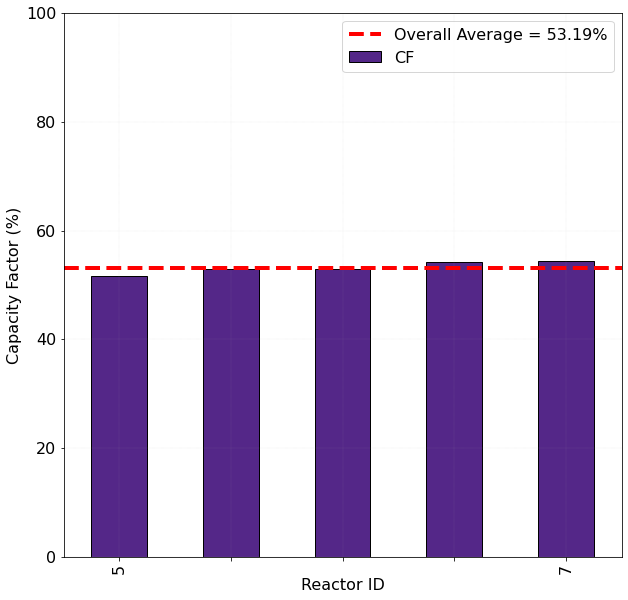

In [381]:
# CF Analysis

if model_name == 'ap1000':
    custom_colors = ['#542788']
else:
    custom_colors = ['#00429d']

# Calculate the sum of 'alpha' for each unique 'r_id' and divide by the last day
results = master_kinfTable.groupby('r_id')['alpha'].sum() / last_day * 100

# Sort the results
sorted_results = results.sort_values()

# Calculate the overall average of 'alpha'
overall_average = sorted_results.mean()

# Create a list of reactor IDs for x-axis labels (starting from 1 and then every 5th)
x_sequence = range(1, len(sorted_results) + 1)
xtick_labels = [str(int(r_id)) if (i == 0 or (i + 1) % 5 == 0) else '' for i, r_id in enumerate(sorted_results.index)]

# Plot the sorted results as a bar plot
fig, ax1 = plt.subplots(figsize=(10, 10))

# Plot the bar chart on the primary axis
sorted_results.plot(kind='bar', ax=ax1, color=custom_colors, edgecolor='black', label='CF')

# Set labels and title for the primary axis
ax1.set_xlabel('Reactor ID')
ax1.set_ylabel('Capacity Factor (%)')
# ax1.set_title(f'{model_name}, VRE%={int(VRE_percentage*100)}, q={q}, cost_frac={cost_frac}, pmin={pmin}')

# Set x-tick labels to show only every 5th reactor ID, starting from 1
ax1.set_xticklabels(xtick_labels, rotation=90)

# Add grid and adjust y-axis
ax1.grid(linestyle='--', linewidth=0.1)
ax1.set_ylim(0, 100)

# Plot the overall average line on the primary axis (ax1)
ax1.axhline(overall_average, color='red', linestyle='--', linewidth=4, label=f'Overall Average = {overall_average:.2f}%')

# Add the legend to the primary axis
ax1.legend(loc='upper right')

# Display the plot
plt.show()

plot_path = os.getcwd() + '/plots/'

# fig.savefig(plot_path + f'{model_name}_generation_{VRE_percentage}vre_q{q}_cf{cost_frac}_pmin{pmin}_reactor_cf.png', dpi=300)


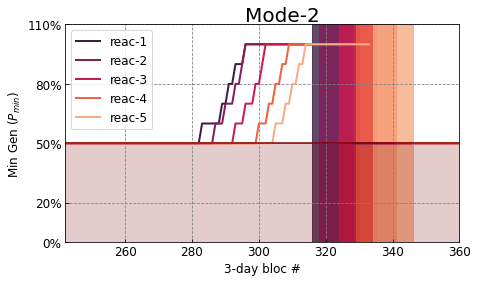

In [747]:
plot_df = master_kinfTable.copy()

# === Mark refueling (nearest_k <= 1.002 treated as keff collapse) ===
if model_name == 'ap1000':
    plot_df.loc[plot_df['nearest_k'] <= 1.002, 'nearest_k'] = 0

# === p0 processing ===
plot_df.loc[plot_df['nearest_k'] == 0, 'p0'] = np.nan  # Hide during refueling

# Clamp valid p0 to min 0.5 if needed
if model_name == 'ap1000':
    plot_df.loc[(plot_df['p0'] < 0.5), 'p0'] = 0.5
else:
    plot_df.loc[(plot_df['p0'] < 0.5) & (plot_df['p0'] > 0), 'p0'] = 0.5

# Scale to percent
plot_df['p0_scaled'] = plot_df['p0'] * 100

# === Setup for plotting ===
unique_r_ids = plot_df['r_id'].unique()
colors = sns.color_palette("rocket", len(unique_r_ids))
fig, ax1 = plt.subplots(figsize=(8, 4))

# === Plot each reactor's p0 and refueling spans ===
for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        if not subset_df['p0_scaled'].dropna().empty:
            ax1.plot(subset_df['p0_scaled'], label=f"r_id {int(r_id)}", color=colors[idx], lw=2)

        # --- Highlight refueling periods (nearest_k == 0) ---
        is_refuel = (subset_df['nearest_k'] == 0).astype(int)
        diff = is_refuel.diff().fillna(0)

        start_indices = diff[diff == 1].index.tolist()
        end_indices = diff[diff == -1].index.tolist()

        # Handle edge cases where refueling starts at index 0 or ends at last
        if is_refuel.iloc[0] == 1:
            start_indices = [0] + start_indices
        if is_refuel.iloc[-1] == 1:
            end_indices = end_indices + [len(is_refuel) - 1]

        for start, end in zip(start_indices, end_indices):
            ax1.axvspan(start, end, color=colors[idx], alpha=0.8)

# === Axis setup ===
ax1.set_xlim([242, 360])
ax1.set_ylim([0, 100])
ax1.set_xlabel('3-day bloc #')
ax1.set_ylabel('Min Gen ($P_{min}$)')
ax1.set_yticks([0, 20, 50, 80,110])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.grid(True, linestyle='--', color='gray')
ax1.axhspan(0, 50, facecolor='maroon', alpha=0.2)
ax1.axhline(50, color='maroon', linewidth=1.5)
# ax1.text(130, 30, 'inaccessible', fontsize=14, color='maroon', weight='bold')

# === Legend, layout, title ===
custom_labels = ['reac-1', 'reac-2', 'reac-3','reac-4', 'reac-5']  # example names
ax1.legend(custom_labels, loc='upper left', ncol=1)
# ax1.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
fig.suptitle('Mode-2', fontsize=20, color='black')

plt.show()

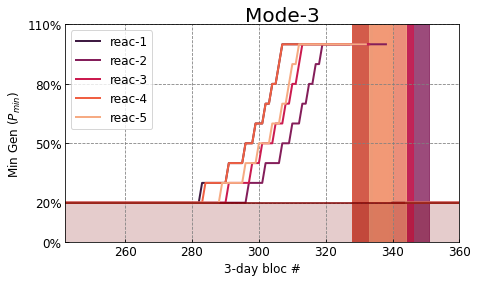

In [743]:
plot_df = master_kinfTable.copy()

# === Mark refueling (nearest_k <= 1.002 treated as keff collapse) ===
if model_name == 'ap1000':
    plot_df.loc[plot_df['nearest_k'] <= 1.002, 'nearest_k'] = 0

# === p0 processing ===
plot_df.loc[plot_df['nearest_k'] == 0, 'p0'] = np.nan  # Hide during refueling

# Clamp valid p0 to min 0.5 if needed
if model_name == 'ap1000':
    plot_df.loc[(plot_df['p0'] < 0.2), 'p0'] = 0.2
else:
    plot_df.loc[(plot_df['p0'] < 0.2) & (plot_df['p0'] > 0), 'p0'] = 0.2

# Scale to percent
plot_df['p0_scaled'] = plot_df['p0'] * 100

# === Setup for plotting ===
unique_r_ids = plot_df['r_id'].unique()
colors = sns.color_palette("rocket", len(unique_r_ids))
fig, ax1 = plt.subplots(figsize=(8, 4))

# === Plot each reactor's p0 and refueling spans ===
for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        if not subset_df['p0_scaled'].dropna().empty:
            ax1.plot(subset_df['p0_scaled'], label=f"r_id {int(r_id)}", color=colors[idx], lw=2)

        # --- Highlight refueling periods (nearest_k == 0) ---
        is_refuel = (subset_df['nearest_k'] == 0).astype(int)
        diff = is_refuel.diff().fillna(0)

        start_indices = diff[diff == 1].index.tolist()
        end_indices = diff[diff == -1].index.tolist()

        # Handle edge cases where refueling starts at index 0 or ends at last
        if is_refuel.iloc[0] == 1:
            start_indices = [0] + start_indices
        if is_refuel.iloc[-1] == 1:
            end_indices = end_indices + [len(is_refuel) - 1]

        for start, end in zip(start_indices, end_indices):
            ax1.axvspan(start, end, color=colors[idx], alpha=0.8)

# === Axis setup ===
ax1.set_xlim([242, 360])
ax1.set_ylim([0, 100])
ax1.set_xlabel('3-day bloc #')
ax1.set_ylabel('Min Gen ($P_{min}$)')
ax1.set_yticks([0, 20, 50, 80,110])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.grid(True, linestyle='--', color='gray')
ax1.axhspan(0, 20, facecolor='maroon', alpha=0.2)
ax1.axhline(20, color='maroon', linewidth=1.5)
# ax1.text(130, 10, 'inaccessible', fontsize=14, color='maroon', weight='bold')

# === Legend, layout, title ===
custom_labels = ['reac-1', 'reac-2', 'reac-3','reac-4', 'reac-5']  # example names
ax1.legend(custom_labels, loc='upper left', ncol=1)
# ax1.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
fig.suptitle('Mode-3', fontsize=20, color='black')

plt.show()

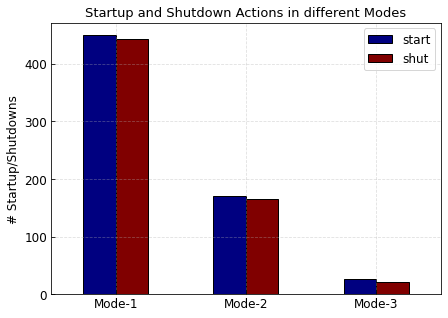

In [607]:
#start/shut analysis

# Combine into single DataFrame
summary_df = pd.DataFrame({
    'mode': ['Mode-1', 'Mode-2', 'Mode-3'],
    'start': [int(mode_1['start'][0]), int(mode_2['start'][0]), int(mode_3['start'][0])],
    'shut': [int(mode_1['shut'][0]), int(mode_2['shut'][0]), int(mode_3['shut'][0])]
})

# Set academic style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'xtick.direction': 'in',
    'ytick.direction': 'in'
})

color_map = {'start': 'navy', 'shut': 'maroon'}
colors = [color_map['start'], color_map['shut']]


# Plot
ax = summary_df.set_index('mode')[['start', 'shut']].plot(
    kind='bar', 
    figsize=(7, 5), 
    color=colors,
    edgecolor='black'
)


# Axis labels and title
ax.set_ylabel('# Startup/Shutdowns')
ax.set_xlabel('')
ax.set_title('Startup and Shutdown Actions in different Modes')
ax.set_xticklabels(summary_df['mode'], rotation=0)

# Grid and spines
ax.grid(linestyle='--', alpha=0.4)

plot_path = path + '/plots'
# plt.savefig(plot_path +'/start_shut_modes.png')


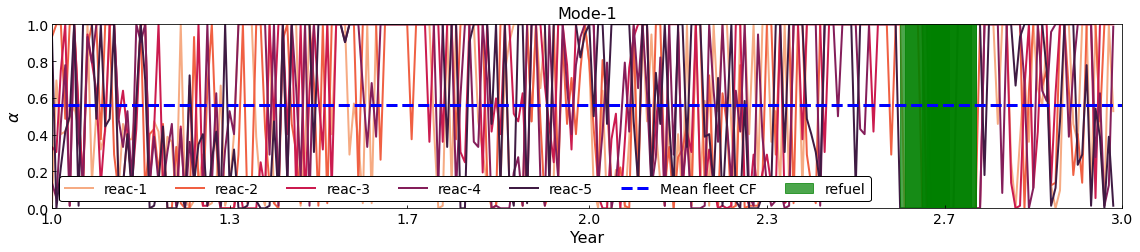

In [714]:
# Copy and preprocess
plot_df = master_kinfTable.copy()
if model_name == 'ap1000':
    plot_df.loc[plot_df['nearest_k'] <= 1.002, ['nearest_k', 'alpha']] = 0

# Unique reactor IDs and color palette
unique_r_ids = plot_df['r_id'].unique()
colors_1 = sns.color_palette("rocket", len(unique_r_ids))[::-1]

# === Plotting setup ===
fig, ax1 = plt.subplots(figsize=(16, 3.5))

for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        ax1.plot(subset_df['alpha'], label=f"gen id {int(r_id)}",
                 color=colors_1[idx], lw=2, alpha=1, zorder=0)

        # Identify and shade refueling period where nearest_k == 0
        zero_mask = subset_df['nearest_k'] == 0
        if zero_mask.any():
            start_idx = zero_mask.idxmax()
            end_idx = zero_mask[::-1].idxmax()
            ax1.axvspan(start_idx, end_idx, color='green', alpha=0.7, zorder=1)

# === Compute overall average (all fleet, all time, excluding r_id==1) ===
overall_mean_alpha = plot_df.loc[plot_df['r_id'] != 1, 'alpha'].mean()

# plot horizontal line across x-axis range
h_mean = ax1.axhline(overall_mean_alpha, color='blue', lw=3, linestyle='--',
                     label='Overall mean $\\alpha$', zorder=2)

# === Axis formatting ===
ax1.set_ylabel('$\\alpha$', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylim(0, 1)
ax1.set_xlim(121, 360)

# Conversion: 3-day blocks → years
blocks_per_year = 365 / 3.0  # ≈ 121.67
# make ticks every 0.5 years
year_ticks = np.arange(1, 3, 0.33)  # up to ~3 years
xticks_blocks = (year_ticks * blocks_per_year).astype(int)
ax1.set_xticks(xticks_blocks)
ax1.set_xticklabels([f"{yt:.1f}" for yt in year_ticks])

ax1.tick_params(axis='both', which='major', labelsize=14)


# Legends
custom_labels = ['reac-1', 'reac-2', 'reac-3',
                 'reac-4', 'reac-5', 'Mean fleet CF', 'refuel']

leg2 = ax1.legend(custom_labels, loc='lower left', ncol=7,
                  frameon=True, facecolor='white', edgecolor='black',
                  framealpha=1.0, fontsize=14)


# === Final layout and plot ===
plt.tight_layout()
plt.title('Mode-1', fontsize=16)

plot_path = path + '/plots'
plt.savefig(plot_path + '/mode1_keff_refuel_shaded.png')
plt.show()


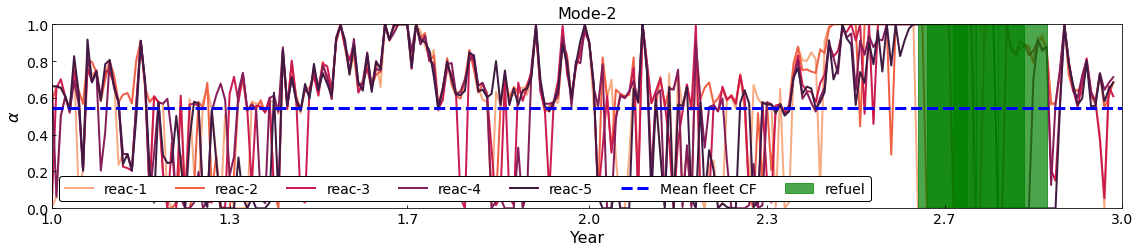

In [710]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns

# Copy and preprocess
plot_df = master_kinfTable.copy()
if model_name == 'ap1000':
    plot_df.loc[plot_df['nearest_k'] <= 1.002, ['nearest_k', 'alpha']] = 0

# Unique reactor IDs and color palette
unique_r_ids = plot_df['r_id'].unique()
colors_1 = sns.color_palette("rocket", len(unique_r_ids))[::-1]

# === Plotting setup ===
fig, ax1 = plt.subplots(figsize=(16, 3.5))

for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        ax1.plot(subset_df['alpha'], label=f"gen id {int(r_id)}",
                 color=colors_1[idx], lw=2, alpha=1, zorder=0)

        # Identify and shade refueling period where nearest_k == 0
        zero_mask = subset_df['nearest_k'] == 0
        if zero_mask.any():
            start_idx = zero_mask.idxmax()
            end_idx = zero_mask[::-1].idxmax()
            ax1.axvspan(start_idx, end_idx, color='green', alpha=0.7, zorder=1)

# === Compute overall average (all fleet, all time, excluding r_id==1) ===
overall_mean_alpha = plot_df.loc[plot_df['r_id'] != 1, 'alpha'].mean()

# plot horizontal line across x-axis range
h_mean = ax1.axhline(overall_mean_alpha, color='blue', lw=3, linestyle='--',
                     label='Overall mean $\\alpha$', zorder=2)

# === Axis formatting ===
ax1.set_ylabel('$\\alpha$', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylim(0, 1)
ax1.set_xlim(121, 360)

# Conversion: 3-day blocks → years
blocks_per_year = 365 / 3.0  # ≈ 121.67
# make ticks every 0.5 years
year_ticks = np.arange(1, 3, 0.33)  # up to ~3 years
xticks_blocks = (year_ticks * blocks_per_year).astype(int)
ax1.set_xticks(xticks_blocks)
ax1.set_xticklabels([f"{yt:.1f}" for yt in year_ticks])

ax1.tick_params(axis='both', which='major', labelsize=14)


# Legends
custom_labels = ['reac-1', 'reac-2', 'reac-3',
                 'reac-4', 'reac-5', 'Mean fleet CF', 'refuel']

leg2 = ax1.legend(custom_labels, loc='lower left', ncol=7,
                  frameon=True, facecolor='white', edgecolor='black',
                  framealpha=1.0, fontsize=14)


# === Final layout and plot ===
plt.tight_layout()
plt.title('Mode-2', fontsize=16)

plot_path = path + '/plots'
plt.savefig(plot_path + '/mode2_keff_refuel_shaded.png')
plt.show()


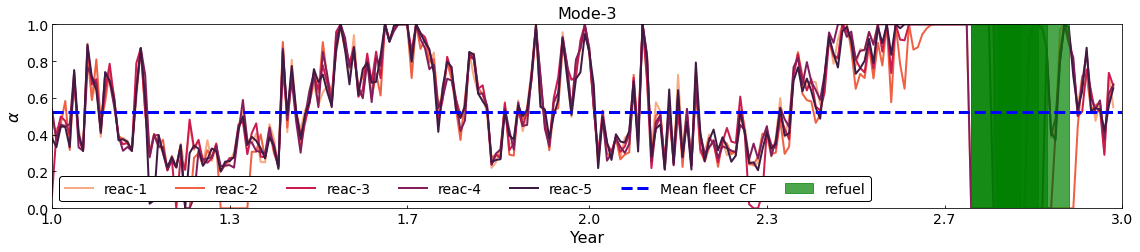

In [712]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns

# Copy and preprocess
plot_df = master_kinfTable.copy()
if model_name == 'ap1000':
    plot_df.loc[plot_df['nearest_k'] <= 1.002, ['nearest_k', 'alpha']] = 0

# Unique reactor IDs and color palette
unique_r_ids = plot_df['r_id'].unique()
colors_1 = sns.color_palette("rocket", len(unique_r_ids))[::-1]

# === Plotting setup ===
fig, ax1 = plt.subplots(figsize=(16, 3.5))

for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        ax1.plot(subset_df['alpha'], label=f"gen id {int(r_id)}",
                 color=colors_1[idx], lw=2, alpha=1, zorder=0)

        # Identify and shade refueling period where nearest_k == 0
        zero_mask = subset_df['nearest_k'] == 0
        if zero_mask.any():
            start_idx = zero_mask.idxmax()
            end_idx = zero_mask[::-1].idxmax()
            ax1.axvspan(start_idx, end_idx, color='green', alpha=0.7, zorder=1)

# === Compute overall average (all fleet, all time, excluding r_id==1) ===
overall_mean_alpha = plot_df.loc[plot_df['r_id'] != 1, 'alpha'].mean()

# plot horizontal line across x-axis range
h_mean = ax1.axhline(overall_mean_alpha, color='blue', lw=3, linestyle='--',
                     label='Overall mean $\\alpha$', zorder=2)

# === Axis formatting ===
ax1.set_ylabel('$\\alpha$', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylim(0, 1)
ax1.set_xlim(121, 360)

# Conversion: 3-day blocks → years
blocks_per_year = 365 / 3.0  # ≈ 121.67
# make ticks every 0.5 years
year_ticks = np.arange(1, 3, 0.33)  # up to ~3 years
xticks_blocks = (year_ticks * blocks_per_year).astype(int)
ax1.set_xticks(xticks_blocks)
ax1.set_xticklabels([f"{yt:.1f}" for yt in year_ticks])

ax1.tick_params(axis='both', which='major', labelsize=14)


# Legends
custom_labels = ['reac-1', 'reac-2', 'reac-3',
                 'reac-4', 'reac-5', 'Mean fleet CF', 'refuel']

leg2 = ax1.legend(custom_labels, loc='lower left', ncol=7,
                  frameon=True, facecolor='white', edgecolor='black',
                  framealpha=1.0, fontsize=14)


# === Final layout and plot ===
plt.tight_layout()
plt.title('Mode-3', fontsize=16)

plot_path = path + '/plots'
plt.savefig(plot_path + '/mode3_keff_refuel_shaded.png')
plt.show()


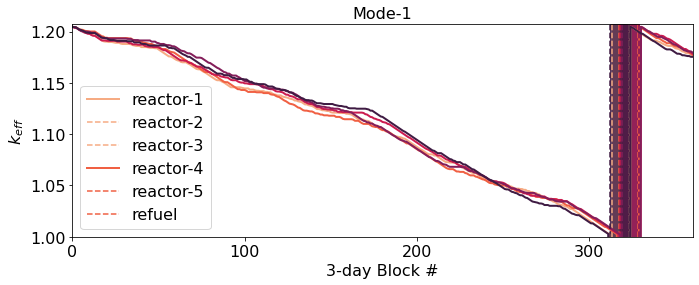

In [368]:
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16, 'text.color': 'black'})

# result_path='/Users/shinychoudhury/Library/CloudStorage/Dropbox/TYNAN_Lab/Research/5_NuclearReactor_technical/physics-informed-nuclear-fleet-unit-commitment/results/mode1_pmin1_PHSduration4_costfrac1.0_kinit1.205_startday0_endday360_refuelspan10'
# # master_df=pd.read_csv(result_path + '/aggregate_results.csv')
# # master_shut_df=pd.read_csv(result_path + '/shut_count_and_obj_value.csv')
# master_kinfTable=pd.read_csv(result_path + '/master_kinfTable.csv')

# === Data preparation ===
plot_df = master_kinfTable.copy()

# Apply rules on 'p0'
if model_name == 'ap1000':
    plot_df.loc[plot_df['p0'] < 0.5, 'p0'] = 0.5
    plot_df.loc[plot_df['nearest_k'] <= 1.002, 'nearest_k'] = 0
else:
    plot_df.loc[plot_df['p0'] < 0.5, 'p0'] = 0.5

# Unique reactor IDs and color palette
unique_r_ids = plot_df['r_id'].unique()
colors = sns.color_palette("rocket", len(unique_r_ids))[::-1]

# === Plotting setup ===
fig, ax1 = plt.subplots(figsize=(10, 4))

for idx, r_id in enumerate(unique_r_ids):
    if r_id != 1:
        subset_df = plot_df[plot_df['r_id'] == r_id].reset_index(drop=True)
        ax1.plot(subset_df['nearest_k'], label=f"gen id {int(r_id)}", color=colors[idx], lw=2)

        # Identify and shade refueling period where nearest_k == 0
        zero_mask = subset_df['nearest_k'] == 0
        if zero_mask.any():
            start_idx = zero_mask.idxmax()
            end_idx = zero_mask[::-1].idxmax()
            ax1.axvline(start_idx, color=colors[idx], linestyle='--', linewidth=1.5)
            ax1.axvline(end_idx, color=colors[idx], linestyle='--', linewidth=1.5)
            ax1.axvspan(start_idx, end_idx, color=colors[idx], alpha=0.8)

# === Axis formatting ===
ax1.set_ylabel('$k_{eff}$')
ax1.set_xlabel('3-day Block #')
ax1.set_ylim(1.0, 1.207)
ax1.set_xlim(0, 360)
ax1.locator_params(nbins=5)
# ax1.legend(loc='lower left')
custom_labels = ['reactor-1', 'reactor-2', 'reactor-3','reactor-4', 'reactor-5', 'refuel']  # example names
ax1.legend(custom_labels, loc='lower left', ncol=1)

# === Final layout and plot ===
plt.tight_layout()
plt.title('Mode-1', fontsize=16)
# plt.savefig('mode1_keff_refuel_shaded.png', dpi=300)
plt.show()

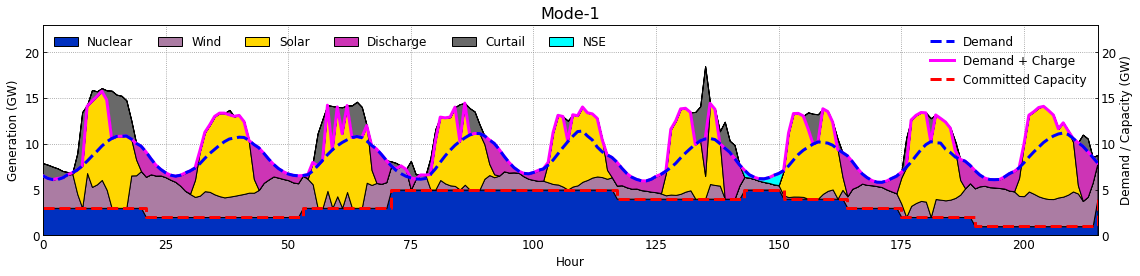

In [527]:
#mode1

start=65
end=start+2
# === Filter data ===
temp = master_df[(master_df['n'] >= start) & (master_df['n'] <= end)].reset_index()
master_commit_temp = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]

# Create relative hour axis (starts from 0)
temp['Hour_rel'] = temp['Hour'] - temp['Hour'].iloc[0]

# Subset plottable columns
plottable = temp[[model_name, 'solar_photovoltaic', 'onshore_wind_turbine',
                  'charge', 'discharge', 'curtail', 'NSE', 'demand']]

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(16, 4))

# === Labels for stackplot (excluding charge) ===
labels = [model_name, 'onshore_wind_turbine', 'solar_photovoltaic',
          'discharge', 'curtail', 'NSE']
labelnames = ['Nuclear', 'Wind', 'Solar', 'Discharge', 'Curtail', 'NSE']

# === Color assignment ===
if model_name == 'ap1000':
    base_colors = ['#0030bf', '#ab7ca3', '#ffd700', '#cd34b5', 'dimgray', 'cyan']
else:
    base_colors = ['#542788', '#feb24c', '#41ab5d', 'yellow', 'red', 'cyan']

# === Grid ===
ax1.grid(True, linestyle='--', color='black', zorder=0)

# === Stackplot (generation) ===
data = [plottable[label].values for label in labels]
ax1.stackplot(temp['Hour_rel'].values, *data, colors=base_colors,
              labels=labelnames, edgecolor='black', zorder=2)

# === Axis labels and limits (primary axis) ===
ax1.set_xlabel('Hour')
ax1.set_ylabel('Generation (GW)')
ax1.set_ylim([0, 23.0e3])
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.tick_params(axis='y', labelcolor='black')

# === Secondary axis: Demand and Committed Capacity ===
ax2 = ax1.twinx()
# demand
ax2.plot(temp['Hour_rel'].values, plottable['demand'].values,
         color='blue', ls='--', label='Demand', linewidth=3, zorder=4)
# demand + charge
ax2.plot(temp['Hour_rel'].values,
         plottable['demand'].values + plottable['charge'].values,
         color='magenta', label='Demand + Charge', linewidth=3, zorder=3)

# committed capacity from master_commit
mc = master_commit_temp.copy()
mc['hour'] = pd.to_numeric(mc['hour'], errors='coerce')
mc['sum_commit'] = pd.to_numeric(mc['sum_commit'], errors='coerce')
mc = mc.dropna(subset=['hour', 'sum_commit']).sort_values('hour').reset_index(drop=True)
mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

ax2.step(mc['Hour_rel'].to_numpy(), mc['sum_commit'].to_numpy(),
         where='post', color='red', ls='--', linewidth=3, label='Committed Capacity')

# secondary axis labels
ax2.set_ylim([0, 23.0e3])
ax2.set_ylabel('Demand / Capacity (GW)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax2.tick_params(axis='y', labelcolor='black')

# X-limits
ax1.set_xlim(0, temp['Hour_rel'].max())

# Title & layout
plt.title('Mode-1', fontsize=16)
# plt.tight_layout()

# Legends
ax1.legend(loc='upper left', ncol=7, frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.grid(True, alpha=0.9, ls=':', color='gray')

plt.tight_layout()
# Save
plot_path = path + '/plots'
plt.savefig(plot_path + '/mode1_long.png')

plt.show()


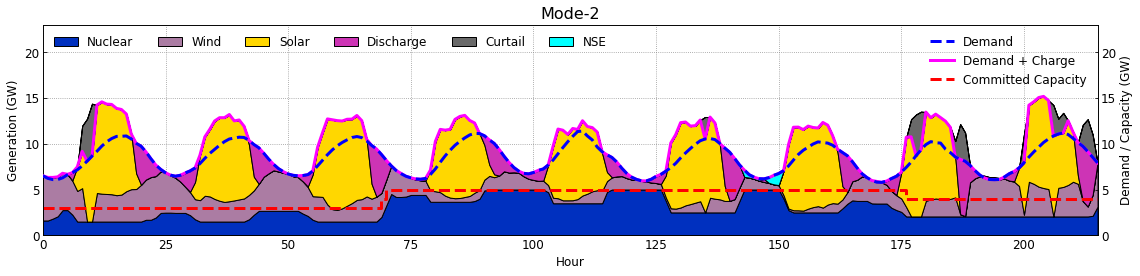

In [524]:
#mode2

start=65
end=start+2
# === Filter data ===
temp = master_df[(master_df['n'] >= start) & (master_df['n'] <= end)].reset_index()
master_commit_temp = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]

# Create relative hour axis (starts from 0)
temp['Hour_rel'] = temp['Hour'] - temp['Hour'].iloc[0]

# Subset plottable columns
plottable = temp[[model_name, 'solar_photovoltaic', 'onshore_wind_turbine',
                  'charge', 'discharge', 'curtail', 'NSE', 'demand']]

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(16, 4))

# === Labels for stackplot (excluding charge) ===
labels = [model_name, 'onshore_wind_turbine', 'solar_photovoltaic',
          'discharge', 'curtail', 'NSE']
labelnames = ['Nuclear', 'Wind', 'Solar', 'Discharge', 'Curtail', 'NSE']

# === Color assignment ===
if model_name == 'ap1000':
    base_colors = ['#0030bf', '#ab7ca3', '#ffd700', '#cd34b5', 'dimgray', 'cyan']
else:
    base_colors = ['#542788', '#feb24c', '#41ab5d', 'yellow', 'red', 'cyan']

# === Grid ===
ax1.grid(True, linestyle='--', color='black', zorder=0)

# === Stackplot (generation) ===
data = [plottable[label].values for label in labels]
ax1.stackplot(temp['Hour_rel'].values, *data, colors=base_colors,
              labels=labelnames, edgecolor='black', zorder=2)

# === Axis labels and limits (primary axis) ===
ax1.set_xlabel('Hour')
ax1.set_ylabel('Generation (GW)')
ax1.set_ylim([0, 23.0e3])
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.tick_params(axis='y', labelcolor='black')

# === Secondary axis: Demand and Committed Capacity ===
ax2 = ax1.twinx()
# demand
ax2.plot(temp['Hour_rel'].values, plottable['demand'].values,
         color='blue', ls='--', label='Demand', linewidth=3, zorder=4)
# demand + charge
ax2.plot(temp['Hour_rel'].values,
         plottable['demand'].values + plottable['charge'].values,
         color='magenta', label='Demand + Charge', linewidth=3, zorder=3)

# committed capacity from master_commit
mc = master_commit_temp.copy()
mc['hour'] = pd.to_numeric(mc['hour'], errors='coerce')
mc['sum_commit'] = pd.to_numeric(mc['sum_commit'], errors='coerce')
mc = mc.dropna(subset=['hour', 'sum_commit']).sort_values('hour').reset_index(drop=True)
mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

ax2.step(mc['Hour_rel'].to_numpy(), mc['sum_commit'].to_numpy(),
         where='post', color='red', ls='--', linewidth=3, label='Committed Capacity')

# secondary axis labels
ax2.set_ylim([0, 23.0e3])
ax2.set_ylabel('Demand / Capacity (GW)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax2.tick_params(axis='y', labelcolor='black')

# X-limits
ax1.set_xlim(0, temp['Hour_rel'].max())

# Title & layout
plt.title('Mode-2', fontsize=16)
# plt.tight_layout()

# Legends
ax1.legend(loc='upper left', ncol=7, frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.grid(True, alpha=0.9, ls=':', color='gray')

plt.tight_layout()
# Save
plot_path = path + '/plots'
plt.savefig(plot_path + '/mode2_long.png')

plt.show()


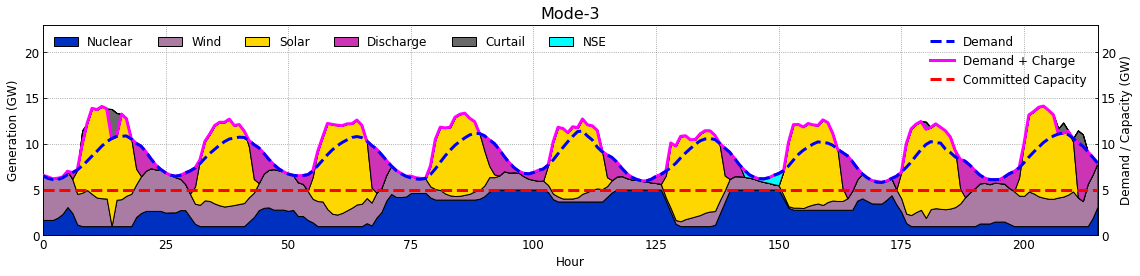

In [521]:
#mode3

start=65
end=start+2

# === Filter data ===
temp = master_df[(master_df['n'] >= start) & (master_df['n'] <= end)].reset_index()
master_commit_temp = master_commit[(master_commit['n'] >= start) & (master_commit['n'] <=end)]

# Create relative hour axis (starts from 0)
temp['Hour_rel'] = temp['Hour'] - temp['Hour'].iloc[0]

# Subset plottable columns
plottable = temp[[model_name, 'solar_photovoltaic', 'onshore_wind_turbine',
                  'charge', 'discharge', 'curtail', 'NSE', 'demand']]

# === Plot setup ===
fig, ax1 = plt.subplots(figsize=(16, 4))

# === Labels for stackplot (excluding charge) ===
labels = [model_name, 'onshore_wind_turbine', 'solar_photovoltaic',
          'discharge', 'curtail', 'NSE']
labelnames = ['Nuclear', 'Wind', 'Solar', 'Discharge', 'Curtail', 'NSE']

# === Color assignment ===
if model_name == 'ap1000':
    base_colors = ['#0030bf', '#ab7ca3', '#ffd700', '#cd34b5', 'dimgray', 'cyan']
else:
    base_colors = ['#542788', '#feb24c', '#41ab5d', 'yellow', 'red', 'cyan']

# === Grid ===
ax1.grid(True, linestyle='--', color='black', zorder=0)

# === Stackplot (generation) ===
data = [plottable[label].values for label in labels]
ax1.stackplot(temp['Hour_rel'].values, *data, colors=base_colors,
              labels=labelnames, edgecolor='black', zorder=2)

# === Axis labels and limits (primary axis) ===
ax1.set_xlabel('Hour')
ax1.set_ylabel('Generation (GW)')
ax1.set_ylim([0, 23.0e3])
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.tick_params(axis='y', labelcolor='black')

# === Secondary axis: Demand and Committed Capacity ===
ax2 = ax1.twinx()
# demand
ax2.plot(temp['Hour_rel'].values, plottable['demand'].values,
         color='blue', ls='--', label='Demand', linewidth=3, zorder=4)
# demand + charge
ax2.plot(temp['Hour_rel'].values,
         plottable['demand'].values + plottable['charge'].values,
         color='magenta', label='Demand + Charge', linewidth=3, zorder=3)

# committed capacity from master_commit
mc = master_commit_temp.copy()
mc['hour'] = pd.to_numeric(mc['hour'], errors='coerce')
mc['sum_commit'] = pd.to_numeric(mc['sum_commit'], errors='coerce')
mc = mc.dropna(subset=['hour', 'sum_commit']).sort_values('hour').reset_index(drop=True)
mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

ax2.step(mc['Hour_rel'].to_numpy(), mc['sum_commit'].to_numpy(),
         where='post', color='red', ls='--', linewidth=3, label='Committed Capacity')

# secondary axis labels
ax2.set_ylim([0, 23.0e3])
ax2.set_ylabel('Demand / Capacity (GW)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax2.tick_params(axis='y', labelcolor='black')

# X-limits
ax1.set_xlim(0, temp['Hour_rel'].max())

# Title & layout
plt.title('Mode-3', fontsize=16)
# plt.tight_layout()

# Legends
ax1.legend(loc='upper left', ncol=7, frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.grid(True, alpha=0.9, ls=':', color='gray')

plt.tight_layout()
# Save
plot_path = path + '/plots'
plt.savefig(plot_path + '/mode3_long.png')

plt.show()


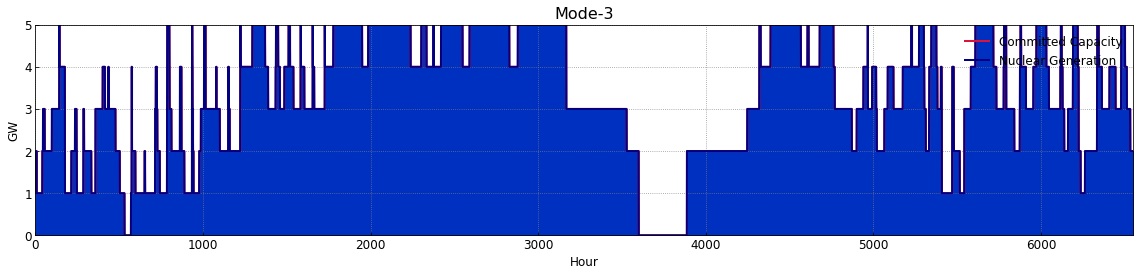

In [722]:
#commitment plot Mode 1


# === Preprocess commit ===
mc = (master_commit
      .assign(hour=pd.to_numeric(master_commit['hour'], errors='coerce'),
              sum_commit=pd.to_numeric(master_commit['sum_commit'], errors='coerce'))
      .dropna(subset=['hour','sum_commit'])
      .groupby('hour', as_index=False)['sum_commit'].sum()
      .sort_values('hour')
      .reset_index(drop=True))

mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

# === Preprocess AP1000 ===
df_ap1000 = master_df[['Hour','ap1000']].copy()
df_ap1000['Hour'] = pd.to_numeric(df_ap1000['Hour'], errors='coerce')
df_ap1000['ap1000'] = pd.to_numeric(df_ap1000['ap1000'], errors='coerce')
df_ap1000 = df_ap1000.dropna().sort_values('Hour').reset_index(drop=True)
df_ap1000['Hour_rel'] = df_ap1000['Hour'] - df_ap1000['Hour'].iloc[0]

# === Plot both on same axis ===
fig, ax1 = plt.subplots(figsize=(16,4))

# Sum commit
x = mc['Hour_rel'].to_numpy()
y = mc['sum_commit'].to_numpy()

ax1.step(x, y, where='post', color='crimson', linewidth=2, label='Committed Capacity')
ax1.fill_between(x, y, 0, step='post', color='crimson', alpha=0.3)  # shaded area under the steps


# AP1000
x = df_ap1000['Hour_rel'].to_numpy()
y = df_ap1000['ap1000'].to_numpy()

ax1.plot(x, y, color='navy', linewidth=2, label='Nuclear Generation')
ax1.fill_between(x, y, 0, color='#0030bf', alpha=1)  # fill from curve down to y=0

# Axis labels & style
ax1.set_xlabel('Hour')
ax1.set_ylabel('GW')
ax1.tick_params(axis='both', colors='black')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.set_ylim([0,5000])
ax1.set_xlim(0, max(mc['Hour_rel'].max(), df_ap1000['Hour_rel'].max()))
ax1.grid(True, alpha=0.9, ls=':', color='gray')

# Legend
ax1.legend(loc='upper right', frameon=False)
plt.title('Mode-3', fontsize=16)

plt.tight_layout()

plot_path=path+'/plots'
# plt.savefig(plot_path+'/mode3_commit.png')

plt.show()


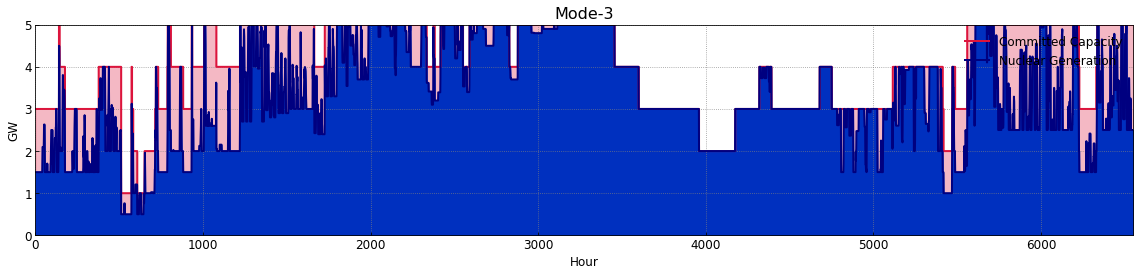

In [724]:
#commitment plot Mode 2


# === Preprocess commit ===
mc = (master_commit
      .assign(hour=pd.to_numeric(master_commit['hour'], errors='coerce'),
              sum_commit=pd.to_numeric(master_commit['sum_commit'], errors='coerce'))
      .dropna(subset=['hour','sum_commit'])
      .groupby('hour', as_index=False)['sum_commit'].sum()
      .sort_values('hour')
      .reset_index(drop=True))

mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

# === Preprocess AP1000 ===
df_ap1000 = master_df[['Hour','ap1000']].copy()
df_ap1000['Hour'] = pd.to_numeric(df_ap1000['Hour'], errors='coerce')
df_ap1000['ap1000'] = pd.to_numeric(df_ap1000['ap1000'], errors='coerce')
df_ap1000 = df_ap1000.dropna().sort_values('Hour').reset_index(drop=True)
df_ap1000['Hour_rel'] = df_ap1000['Hour'] - df_ap1000['Hour'].iloc[0]

# === Plot both on same axis ===
fig, ax1 = plt.subplots(figsize=(16,4))

# Sum commit
x = mc['Hour_rel'].to_numpy()
y = mc['sum_commit'].to_numpy()

ax1.step(x, y, where='post', color='crimson', linewidth=2, label='Committed Capacity')
ax1.fill_between(x, y, 0, step='post', color='crimson', alpha=0.3)  # shaded area under the steps


# AP1000
x = df_ap1000['Hour_rel'].to_numpy()
y = df_ap1000['ap1000'].to_numpy()

ax1.plot(x, y, color='navy', linewidth=2, label='Nuclear Generation')
ax1.fill_between(x, y, 0, color='#0030bf', alpha=1)  # fill from curve down to y=0

# Axis labels & style
ax1.set_xlabel('Hour')
ax1.set_ylabel('GW')
ax1.tick_params(axis='both', colors='black')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.set_ylim([0,5000])
ax1.set_xlim(0, max(mc['Hour_rel'].max(), df_ap1000['Hour_rel'].max()))
ax1.grid(True, alpha=0.9, ls=':', color='gray')

# Legend
ax1.legend(loc='upper right', frameon=False)
plt.title('Mode-3', fontsize=16)

plt.tight_layout()

plot_path=path+'/plots'
# plt.savefig(plot_path+'/mode3_commit.png')

plt.show()


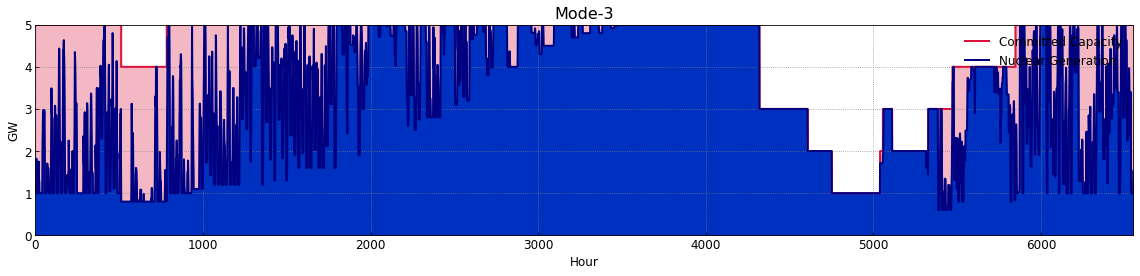

In [726]:
#commitment plot Mode 3


# === Preprocess commit ===
mc = (master_commit
      .assign(hour=pd.to_numeric(master_commit['hour'], errors='coerce'),
              sum_commit=pd.to_numeric(master_commit['sum_commit'], errors='coerce'))
      .dropna(subset=['hour','sum_commit'])
      .groupby('hour', as_index=False)['sum_commit'].sum()
      .sort_values('hour')
      .reset_index(drop=True))

mc['Hour_rel'] = mc['hour'] - mc['hour'].iloc[0]

# === Preprocess AP1000 ===
df_ap1000 = master_df[['Hour','ap1000']].copy()
df_ap1000['Hour'] = pd.to_numeric(df_ap1000['Hour'], errors='coerce')
df_ap1000['ap1000'] = pd.to_numeric(df_ap1000['ap1000'], errors='coerce')
df_ap1000 = df_ap1000.dropna().sort_values('Hour').reset_index(drop=True)
df_ap1000['Hour_rel'] = df_ap1000['Hour'] - df_ap1000['Hour'].iloc[0]

# === Plot both on same axis ===
fig, ax1 = plt.subplots(figsize=(16,4))

# Sum commit
x = mc['Hour_rel'].to_numpy()
y = mc['sum_commit'].to_numpy()

ax1.step(x, y, where='post', color='crimson', linewidth=2, label='Committed Capacity')
ax1.fill_between(x, y, 0, step='post', color='crimson', alpha=0.3)  # shaded area under the steps


# AP1000
x = df_ap1000['Hour_rel'].to_numpy()
y = df_ap1000['ap1000'].to_numpy()

ax1.plot(x, y, color='navy', linewidth=2, label='Nuclear Generation')
ax1.fill_between(x, y, 0, color='#0030bf', alpha=1)  # fill from curve down to y=0

# Axis labels & style
ax1.set_xlabel('Hour')
ax1.set_ylabel('GW')
ax1.tick_params(axis='both', colors='black')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax1.set_ylim([0,5000])
ax1.set_xlim(0, max(mc['Hour_rel'].max(), df_ap1000['Hour_rel'].max()))
ax1.grid(True, alpha=0.9, ls=':', color='gray')

# Legend
ax1.legend(loc='upper right', frameon=False)
plt.title('Mode-3', fontsize=16)

plt.tight_layout()

plot_path=path+'/plots'
# plt.savefig(plot_path+'/mode3_commit.png')

plt.show()
